In [1]:
%run set_jupyter.py
%matplotlib inline 

当前工作目录：D:\dlquant
matplotlib显示字体已设置为中文。


In [2]:
import torch
from torch.nn.modules.loss import MSELoss, CrossEntropyLoss
from torch.nn import MSELoss 

from pytorch_lightning import Trainer, loggers as pl_loggers  
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
 
from darts.utils.callbacks import TFMProgressBar
from darts.models import TiDEModel
from darts.metrics import mape, mse, mae
from sklearn.metrics import mean_squared_error, precision_score 

import optuna  
from pathlib import Path

# 自定义
from config import TIMESERIES_LENGTH # 测试和验证数据长度设置
from data_precessing.timeseries import prepare_timeseries_data  # 获取训练数据、验证数据和测试数据
from utils.model import MAPELoss, LossLogger
from config import TIMESERIES_LENGTH

C:\Users\huron\AppData\Local\pypoetry\Cache\virtualenvs\dlquant-vxVcaLmo-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 全局变量

In [3]:
loss_logger = LossLogger()
progress_bar = TFMProgressBar(  
        enable_sanity_check_bar=False, enable_validation_bar=False  
    ) 

early_stopper = EarlyStopping(  
            monitor="val_loss",  
            patience=10,  
            min_delta=1e-6,  
            mode="min",  
        )  
model_name = "TiDEModel"
work_dir = Path(f"logs/{model_name}_logs").resolve() 
work_dir

WindowsPath('D:/dlquant/logs/TiDEModel_logs')

# 读取数据

In [4]:
data = prepare_timeseries_data('training')

***** xtdata连接成功 *****
服务信息: {'tag': 'sp3', 'version': '1.0'}
服务地址: 127.0.0.1:58610
数据路径: C:\e_trader\bin.x64/../userdata_mini/datadir
设置xtdata.enable_hello = False可隐藏此消息



2024-09-14 12:50:37 | INFO     | download_xt_data:36 - 成功下载股票数据：510050.SH
2024-09-14 12:50:37 | INFO     | download_xt_data:36 - 成功下载股票数据：510300.SH
2024-09-14 12:50:38 | INFO     | download_xt_data:36 - 成功下载股票数据：510500.SH
2024-09-14 12:50:38 | INFO     | download_xt_data:36 - 成功下载股票数据：511260.SH
2024-09-14 12:50:38 | INFO     | download_xt_data:36 - 成功下载股票数据：511010.SH
2024-09-14 12:50:38 | INFO     | download_xt_data:36 - 成功下载股票数据：512010.SH
2024-09-14 12:50:38 | INFO     | download_xt_data:36 - 成功下载股票数据：512040.SH
2024-09-14 12:50:38 | INFO     | download_xt_data:36 - 成功下载股票数据：512690.SH
2024-09-14 12:50:38 | INFO     | download_xt_data:36 - 成功下载股票数据：512290.SH
2024-09-14 12:50:38 | INFO     | download_xt_data:36 - 成功下载股票数据：513050.SH
2024-09-14 12:50:39 | INFO     | download_xt_data:36 - 成功下载股票数据：513100.SH
2024-09-14 12:50:39 | INFO     | download_xt_data:36 - 成功下载股票数据：513500.SH
2024-09-14 12:50:39 | INFO     | download_xt_data:36 - 成功下载股票数据：513880.SH
2024-09-14 12:50:39 | INFO     | downl

# 模型参数

In [5]:


class DartsParameters:
    
    def get_pl_trainer_kwargs(self, full_training=True):  
        # 提前停止：若验证损失在10个epoch内没有减少1e-6则停止  
        early_stopper = EarlyStopping(  
            monitor="val_loss",  
            patience=10,  
            min_delta=1e-6,  
            mode="min",  
        )  
        
        # PyTorch Lightning Trainer参数配置（可添加自定义回调）  
        if full_training:  
            limit_train_batches = None  
            limit_val_batches = None  
            max_epochs = 200  
            batch_size = 64  
        else:  
            limit_train_batches = 20  
            limit_val_batches = 10  
            max_epochs = 40  
            batch_size = 64  
        
        # 仅显示训练和预测进度条  
        progress_bar = TFMProgressBar(  
            enable_sanity_check_bar=False, enable_validation_bar=False  
        )  
        
        pl_trainer_kwargs = {  
            "gradient_clip_val": 1,  # 梯度剪裁，通过限制梯度的范围来稳定训练过程  
            "max_epochs": max_epochs,  
            "limit_train_batches": limit_train_batches,  
            "limit_val_batches": limit_val_batches,  
            "accelerator": "auto",  
            "callbacks": [early_stopper, progress_bar, loss_logger],  
        }  
        
        return pl_trainer_kwargs  

    # 获取优化器的参数配置  
    def get_optimizer_kwargs(self):  
        # 优化器配置，默认使用Adam  
        optimizer_kwargs = {  
            "lr": 1e-4,  
            # "optimizer_cls": torch.optim.Adam  
        }  
        return optimizer_kwargs

In [6]:
class TiDEModelParameters(DartsParameters):  
    def __init__(  
        self,  
        input_chunk_length=85,   
        output_chunk_length=14,   
        output_chunk_shift=0,   
        num_encoder_layers=10,   
        num_decoder_layers=4,   
        decoder_output_dim=24,   
        hidden_size=215,   
        temporal_width_past=2,   
        temporal_width_future=9,   
        temporal_decoder_hidden=10,   
        use_layer_norm=True,   
        dropout=0.105,   
        use_static_covariates=True,  
        use_reversible_instance_norm=False  
    ):  
        self.input_chunk_length = input_chunk_length  
        self.output_chunk_length = output_chunk_length  
        self.output_chunk_shift = output_chunk_shift  
        self.num_encoder_layers = num_encoder_layers  
        self.num_decoder_layers = num_decoder_layers  
        self.decoder_output_dim = decoder_output_dim  
        self.hidden_size = hidden_size  
        self.temporal_width_past = temporal_width_past  
        self.temporal_width_future = temporal_width_future  
        self.temporal_decoder_hidden = temporal_decoder_hidden  
        self.use_layer_norm = use_layer_norm  
        self.dropout = dropout  
        self.use_static_covariates = use_static_covariates  
        self.use_reversible_instance_norm = use_reversible_instance_norm  

        loss_fn="binary_cross_entropy"

        self.optimizer_kwargs = self.get_optimizer_kwargs()  
        # PyTorch Lightning Trainer参数  
        self.pl_trainer_kwargs = self.get_pl_trainer_kwargs(True) 

        self.work_dir = work_dir  
        self.save_checkpoints = True
        self.force_reset=True

    def __repr__(self):  
        return (  
            f"TiDEModelParameters(input_chunk_length={self.input_chunk_length}, "  
            f"output_chunk_length={self.output_chunk_length}, "  
            f"output_chunk_shift={self.output_chunk_shift}, "  
            f"num_encoder_layers={self.num_encoder_layers}, "  
            f"num_decoder_layers={self.num_decoder_layers}, "  
            f"decoder_output_dim={self.decoder_output_dim}, "  
            f"hidden_size={self.hidden_size}, "  
            f"temporal_width_past={self.temporal_width_past}, "  
            f"temporal_width_future={self.temporal_width_future}, "  
            f"temporal_decoder_hidden={self.temporal_decoder_hidden}, "  
            f"use_layer_norm={self.use_layer_norm}, "  
            f"dropout={self.dropout}, "  
            f"use_static_covariates={self.use_static_covariates}, "  
            f"use_reversible_instance_norm={self.use_reversible_instance_norm})"  
        )     

In [7]:
parameters = TiDEModelParameters()
vars(parameters)

{'input_chunk_length': 85,
 'output_chunk_length': 14,
 'output_chunk_shift': 0,
 'num_encoder_layers': 10,
 'num_decoder_layers': 4,
 'decoder_output_dim': 24,
 'hidden_size': 215,
 'temporal_width_past': 2,
 'temporal_width_future': 9,
 'temporal_decoder_hidden': 10,
 'use_layer_norm': True,
 'dropout': 0.105,
 'use_static_covariates': True,
 'use_reversible_instance_norm': False,
 'optimizer_kwargs': {'lr': 0.0001},
 'pl_trainer_kwargs': {'gradient_clip_val': 1,
  'max_epochs': 200,
  'limit_train_batches': None,
  'limit_val_batches': None,
  'accelerator': 'auto',
  'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping at 0x24725a0d190>,
   <utils.model.LossLogger at 0x247246b1f50>]},
 'work_dir': WindowsPath('D:/dlquant/logs/TiDEModel_logs'),
 'save_checkpoints': True,
 'force_reset': True}

In [8]:
model = TiDEModel(
    **vars(parameters),
    model_name = model_name
)

# 训练模型

In [9]:
model.fit(
    # 训练集
    series=data['train'],
    past_covariates=data['past_covariates'],
    future_covariates=data['future_covariates'],
    # 验证集
    val_series=data['val'],
    val_past_covariates=data['past_covariates'],
    val_future_covariates=data['future_covariates'],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | past_cov_projection   | _ResidualBlock   | 365 K  | train
6  | future_cov_projection | _ResidualBlock   | 11.1 K | train
7  | encoders              | Sequential       | 3.3 M  | train
8  | decoders              | Sequential       | 611 K  | train
9  | temporal_decoder      | _ResidualBlock   | 2.3 K  | train
10 | lookback_skip         | Linear           | 1.2 K  | train
---------------------------------------------------------------

Epoch 173: 100%|██████████| 56/56 [00:27<00:00,  2.03it/s, train_loss=0.058, val_loss=0.229] 


TiDEModel(output_chunk_shift=0, num_encoder_layers=10, num_decoder_layers=4, decoder_output_dim=24, hidden_size=215, temporal_width_past=2, temporal_width_future=9, temporal_decoder_hidden=10, use_layer_norm=True, dropout=0.105, use_static_covariates=True, input_chunk_length=85, output_chunk_length=14, use_reversible_instance_norm=False, optimizer_kwargs={'lr': 0.0001}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 200, 'limit_train_batches': None, 'limit_val_batches': None, 'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000002472278B0D0>, <darts.utils.callbacks.TFMProgressBar object at 0x000002472278B6D0>, <utils.model.LossLogger object at 0x000002472278A9D0>]}, work_dir=D:\dlquant\logs\TiDEModel_logs, save_checkpoints=True, force_reset=True, model_name=TiDEModel)

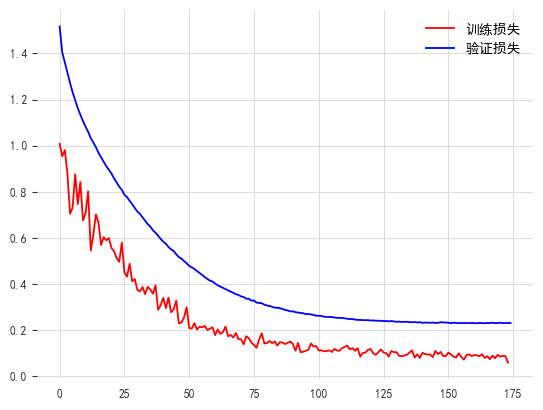

In [10]:
plt.plot(loss_logger.train_loss, label='训练损失', color='red')
plt.plot(loss_logger.val_loss, label='验证损失', color='blue')
plt.legend()

# 性能评估

In [11]:
# 加载最优模型
model = model.load_from_checkpoint(model_name=model_name, work_dir=work_dir)

C:\Users\huron\AppData\Local\pypoetry\Cache\virtualenvs\dlquant-vxVcaLmo-py3.11\Lib\site-packages\darts\models\forecasting\torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to 

In [12]:
# we will predict the next `pred_steps` points after the end of `pred_input`
pred_steps = TIMESERIES_LENGTH["test_length"]
pred_input = data["test"][:-pred_steps]


# result_accumulator = {}
# # predict with each model and compute/store the metrics against the test sets
# for model_name, model in models.items():
pred_series = model.predict(n=pred_steps, series=pred_input)



# result_accumulator[model_name] = {
#     "mae": mae(test, pred_series),
#     "mse": mse(test, pred_series),
# }

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.05it/s]


In [13]:
# 假设 data["test"] 和 pred_series 是 Darts生成的 TimeSeries 对象或者类似结构  
# 提取并转换 DataArray 中的数据为 NumPy 数组  
true_labels = data["test"][-pred_steps:].values()  
true_labels = true_labels.astype(int).flatten()  # Flatten to 1D  

# 对预测结果进行二值化和展平  
binary_predictions = pred_series.values() > 0.5  
binary_predictions = binary_predictions.astype(int).flatten()  

# 计算精确率  
precision = precision_score(true_labels, binary_predictions)  

In [14]:
precision

0.398488120950324

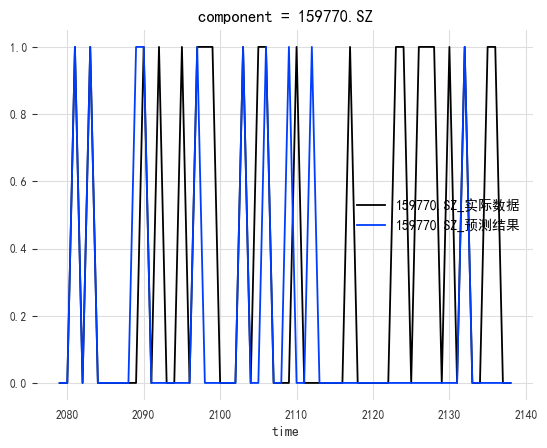

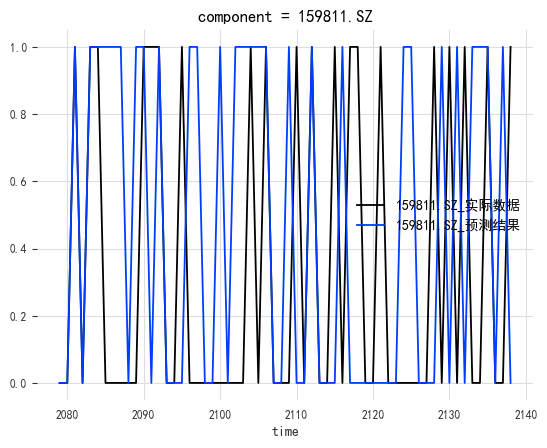

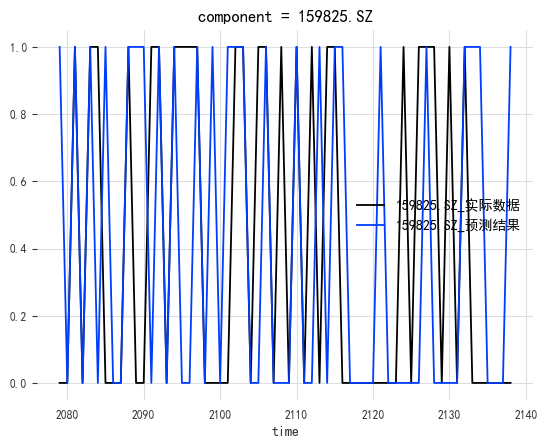

In [15]:
for i, stock in enumerate(data["test"].columns[:3]):
    data["test"][-pred_steps:].data_array().sel(component=stock).plot(label=f"{stock}_实际数据")
    (pred_series.data_array().sel(component=stock) > 0.5).astype(int).plot(label=f"{stock}_预测结果")
    # data['test'].slice_intersect(hfc).data_array().sel(component=stock).plot(label=f"{stock}_实际数据")
    plt.legend()
    plt.show()

# 超参数调优

In [16]:
def objective(trial): 
    input_chunk_length = trial.suggest_int("input_chunk_length", 3, 128)  
    output_chunk_length = trial.suggest_int("output_chunk_length",1, 64)  
    # output_chunk_shift = trial.suggest_int("output_chunk_shift", 0, 10)  
    num_encoder_layers = trial.suggest_int("num_encoder_layers", 1, 10)  
    num_decoder_layers = trial.suggest_int("num_decoder_layers", 1, 10)  
    decoder_output_dim = trial.suggest_int("decoder_output_dim", 8, 32)  
    hidden_size = trial.suggest_int("hidden_size", 64, 256)  
    temporal_width_past = trial.suggest_int("temporal_width_past", 1, 10)  
    temporal_width_future = trial.suggest_int("temporal_width_future", 1, 10)  
    temporal_decoder_hidden = trial.suggest_int("temporal_decoder_hidden", 8, 64)  
    use_layer_norm = trial.suggest_categorical("use_layer_norm", [True, False])  
    dropout = trial.suggest_float("dropout", 0, 0.5)  

    params = TiDEModelParameters(  
        input_chunk_length=input_chunk_length,   
        output_chunk_length=output_chunk_length,   
        # output_chunk_shift=output_chunk_shift,   
        num_encoder_layers=num_encoder_layers,   
        num_decoder_layers=num_decoder_layers,   
        decoder_output_dim=decoder_output_dim,   
        hidden_size=hidden_size,   
        temporal_width_past=temporal_width_past,   
        temporal_width_future=temporal_width_future,   
        temporal_decoder_hidden=temporal_decoder_hidden,   
        use_layer_norm=use_layer_norm,   
        dropout=dropout, 
    )  

    logger = pl_loggers.TensorBoardLogger("/data/tb_logs", name=model_name)  

    model_checkpoint = ModelCheckpoint(  
        monitor='val_loss',  
        dirpath=f"/tata/optuna/trial_{trial.number}_checkpoints",  
        filename='{epoch}-{val_loss:.2f}',  
        save_top_k=1,  
        mode='min'  
    )  

    trainer = Trainer(  
        logger=logger,  
        callbacks=[model_checkpoint, progress_bar, early_stopper],  
        max_epochs=params.pl_trainer_kwargs['max_epochs'],  
        limit_train_batches=params.pl_trainer_kwargs['limit_train_batches'],  
        limit_val_batches=params.pl_trainer_kwargs['limit_val_batches'],  
        accelerator=params.pl_trainer_kwargs['accelerator']  
    )  

    model = TiDEModel(**vars(params), model_name=model_name)  

    # 训练模型  
    model.fit( 

        series=data['train'],
        past_covariates=data['past_covariates'],
        future_covariates=data['future_covariates'],
        # 验证集
        val_series=data['val'],
        val_past_covariates=data['past_covariates'],
        val_future_covariates=data['future_covariates'],
          
        verbose=True,  
        trainer=trainer  # Now use the trainer  
    )  

    best_model_path = model_checkpoint.best_model_path 
    # model = TiDEModel.load(best_model_path) 
    
    trial.set_user_attr('best_model_path', best_model_path)  

    pred_steps = TIMESERIES_LENGTH["test_length"]
    pred_input = data["test"][:-pred_steps]
    
    pred_series = model.predict(n=pred_steps, series=pred_input)

    true_labels = data["test"][-pred_steps:].values()  
    true_labels = true_labels.astype(int).flatten()  # Flatten to 1D  
    
    # 对预测结果进行二值化和展平  
    binary_predictions = pred_series.values() > 0.5  
    binary_predictions = binary_predictions.astype(int).flatten()  
    
    # 计算精确率  
    precision = precision_score(true_labels, binary_predictions)  

    return -precision

In [17]:
study = optuna.create_study(
    study_name=model_name,   # 变化
    direction="minimize",  
    storage="sqlite:///data/optuna/assoptuna_study.db",  
    load_if_exists=True  
) 

[I 2024-09-14 14:05:57,870] Using an existing study with name 'TiDEModel' instead of creating a new one.


In [18]:
study.optimize(objective, n_trials=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\huron\AppData\Local\pypoetry\Cache\virtualenvs\dlquant-vxVcaLmo-py3.11\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory D:\tata\optuna\trial_208_checkpoints exists and is not empty.

   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | past_cov_projection   | _ResidualBlock   | 389 K  | train
6  | future_cov_projection | _ResidualBlock   | 9.8 K  | train
7  | encoders              | Sequential       | 2.8 M  | train
8  | decoders     

Epoch 80: 100%|██████████| 56/56 [00:22<00:00,  2.51it/s, v_num=204, train_loss=0.0164, val_loss=0.197]

C:\Users\huron\AppData\Local\pypoetry\Cache\virtualenvs\dlquant-vxVcaLmo-py3.11\Lib\site-packages\darts\models\forecasting\torch_forecasting_model.py:1747: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to 

AttributeError: 'dict' object has no attribute '_fit_called'

In [ ]:
print("Best trial:")  
trial = study.best_trial  
print("  Value: ", trial.value)  
print("  Params: ")  
for key, value in trial.params.items():  
    print(f"    {key}: {value}")  

best_model_path = trial.user_attrs['best_model_path']  
print(f"Best model path: {best_model_path}")